# Install dependencies

To ensure that this assignment runs properly on the Colab environment, we must install a few libraries using the `pip` utility.

In [ ]:
import copy
import time
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset


use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

# Setting the seed to a fixed value can be helpful in reproducing results
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

print("PyTorch version: ", torch.__version__)
print("GPU available: {}".format(use_gpu))

PyTorch version:  1.8.0+cu101
GPU available: True



# Objective

Our goal is to build a recurrent model capable of adding an arbitrary series of numbers. It is all in all a fairly simple task (any pocket calculator can trivially do it) yet it will demonstrate that this procedure can be learned from data. Further, we will use it to outline certain limitations of RNNs compared to LSTMs.


# Data description

Our data is composed a set of sequences of numbers each associated with the target, which is sum of each element in that sequence. In other words, the input to our model will be a vector $\mathbf x^{(i)} = \left[x_{1}^{i}, x_{2}^{i}, \dots, x_{T}^{i}\right]$ of length $T$ and a target $y^{(i)}$ given by:

\begin{align}  
y^{(i)}=\sum_{j=1}^{T}x^{(i)}_j,
\end{align}

where $j$ indexes time.

For example, for the input $\mathbf x^{(i)}$ of length $4$, we have:

\begin{align}  
\mathbf x^{(i)} &= \left[ 4,-1,15,24\right]; \\ 
y^{(i)} &= 42.
\end{align}

We will use our data to train both an RNN and an LSTM.

# Generating the dataset

It will be useful to have a function that can generate random datasets of `n_samples` sequences each of length `seq_length`. To do so we will rely on the function [torch.randint()](https://pytorch.org/docs/stable/torch.html#torch.randint). The function `generate_data` takes as input the following arguments:
- **n_samples** (int): number of sequences to generate.
- **seq_len** (int): length of each sequence.
- **input_dim** (int, optional): dimension of the input data. Default: 1.
- **xmin** (float, optional): minimum possible value in the sequence. Default: -100.
- **xmax** (float, optional): maximum possible value in the sequence. Default: -100.

It returns a tuple of two elements corresponding respectively to:
- **X** ([torch.FloatTensor](https://pytorch.org/docs/stable/tensors.html)): A tensor of shape $n\_samples \times seq\_len \times input\_dim$ representing a set of `n_samples` sequences, each of length `seq_len`. The elements of the sequences are of dimension `input_dim`.
- **Y** ([torch.FloatTensor](https://pytorch.org/docs/stable/tensors.html)): A tensor of shape $n\_samples \times  input\_dim$ representing the corresponding sum of the elements for each sequence in `X`.

In [ ]:
def generate_data(n_samples, seq_len, input_dim=1, xmin=-100, xmax=100):
    """Generate tensors X and Y within the [xmin, xmax] interval.
    
    Args : 
      n_samples: int, number of sequences to generate
      seq_len: int, length of each sequence
      input_dim: int, dimension of the input data
      xmin: minimum possible value in the sequence
      xmax: maximum possible value in the sequence
    
    Returns: n_samples sequence of numbers X and associated targets Y in this
             format torch.Tensor where X.shape = (n_samples, seq_len, 1)
             and Y.shape = (n_samples, 1).
    """
    X = torch.randint(xmin, xmax+1, (n_samples, seq_len, input_dim))
    Y = X.sum(dim=1)
    
    return X, Y

The following piece of code shows an example of how to use the `generate_data` function. In this example, we are generating 1000 sequences of numbers, each one of lenght 4.

In [ ]:
n_samples = 1000
seq_len = 4
input_dim = 1
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
print("Tensor dimensions X = {}".format(X.shape))
print("where n_samples = {}, seq_len = {}, input_dim = {}".format(*X.shape))
print("data example: {}".format(X[0,:,0]))

Tensor dimensions X = torch.Size([1000, 4, 1])
where n_samples = 1000, seq_len = 4, input_dim = 1
data example: tensor([ 71,  40, -84,  81])


# Standardizing data

To help the training of our model we will first standardize the input data such that it has, overall, `mean` 0 and standard deviation (`stdev`) 1. To do so we simply calculate the mean and std of our data and then substract the former and divide by the latter. In addition, we will store these two values for later usage. This standardization often speeds up learning.


In [ ]:
def standardize(X):
    """The function standardizes the X tensor. 
    Args:
      X: torch.Tensor.
    
    Returns:
      Xs: torch.Tensor standardize.
      Ys: torch.Tensor, the (new) sum of Xs.
      mean: float, the mean of X.
      stdev: float, the stdev of X.
    """
    
    X=X.float()
    mean = torch.mean(X)
    std = torch.std(X)
    Xs = (X-mean) / std
    Ys = Xs.sum(dim=1)
    
    return Xs, Ys, mean, std


An example of how to use the above defined function is shown below. Here, after generating the data using the generate_data function, we use the standardize function to standardize it.

In [ ]:
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
example_before = X[0,:,0]
Xs, Ys, mean, std = standardize(X)
print("mean = {:.4f}, std = {:.4f}".format(mean, std))
print('example before standardization: {}'.format(X[0,:,0]),
      '\nexample after standardization: {}'.format(Xs[0,:,0])
)

mean = 0.5472, std = 58.2220
example before standardization: tensor([-55,  70, -84,  -9]) 
example after standardization: tensor([-0.9541,  1.1929, -1.4522, -0.1640])


# RNN implementation 

We will define our RNN model using the PyTorch class `torch.nn.RNN()`. Once initialized, it takes input data `X` of shape `(seq_len, batch_size, input_dim)` (recall that we will use `input_dim=1` for our task). We then add a linear layer to transform the last hidden recurrent state to have the same dimensionality as `Y` which has size `(batch_size, input_dim)` (again `input_dim=1`). 

In [ ]:
class RNNLinear(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_size, n_layers):
        super(RNNLinear, self).__init__()
        self.rnn = nn.RNN(input_dim,
                          hidden_size,
                          n_layers)
        
        self.linear = nn.Linear(hidden_size, output_dim)
        
    def forward(self, x):
        # The RNN's input must be of size (seq_len, batch_size, input_dim)
        x = x.transpose(0, 1) 
        output, _ = self.rnn(x)
        pred = self.linear(output[-1])
        return pred

Here is an example of how this class can be used to predict the values of the sequences in Xs.

In [ ]:
n_samples = 50
seq_len = 4
input_dim = 1
output_dim = 1
n_layers = 2
hidden_size = 20

# Data generation
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
Xs, Ys, mean, std = standardize(X)

# Declaration of the RNN model
model_rnn = RNNLinear(input_dim, output_dim, hidden_size, n_layers)

# Transfer the model to the proper device
model_rnn = model_rnn.to(device)

# save its initial weights
init_rnn_weights = copy.deepcopy(model_rnn.state_dict())

# Transfer the data to the proper device
Xs = Xs.to(device)

# Use the RNN to predict the output of each input sequence prior to training
# Ensure that the inputs and output are correct
y_pred = model_rnn(Xs)
print("Size of input data: {}".format(Xs.shape)) # (n_samples, seq_len, input_dim)
print("Size of predictions: {}".format(y_pred.shape)) # (n_samples, input_dim)

Size of input data: torch.Size([50, 4, 1])
Size of predictions: torch.Size([50, 1])


# LSTM implementation

We will now implement an LSTM model using the PyTorch class [torch.nn.LSTM()](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM). Just like with the RNN, we will need to add a linear layer to transform the last recurrent state of our LSTM to have the same dimensions of our target `Y` which has size `(batch_size, input_dim)` (with `input_dim=1` as above).


In [ ]:
class LSTMLinear(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_size, n_layers):
        super(LSTMLinear, self).__init__()
        self.LSTM = nn.LSTM(input_dim,
                            hidden_size,
                            n_layers)
        
        self.linear = nn.Linear(hidden_size, output_dim)
        
    def forward(self, x):
        # the input to an LSTM must be of size (seq_len, batch_size, input_dim)
        x = x.transpose(0, 1)
        output, _ = self.LSTM(x)
        pred = self.linear(output[-1])
        
        return pred
    

Here is an example of how this class can be used to predict the values of the sequences in Xs.

In [ ]:
n_samples = 50
seq_len = 4
input_dim = 1
output_dim = 1
n_layers = 2
hidden_size = 20

# Data generation
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
Xs, Ys, mean, std = standardize(X)

# Declaration of the LSTM model
model_lstm = LSTMLinear(input_dim, output_dim, hidden_size, n_layers)

# Transfer the model to the proper device
model_lstm = model_lstm.to(device)

# save its initial weights
init_lstm_weights = copy.deepcopy(model_lstm.state_dict())

# Transfer the data to the proper device
Xs = Xs.to(device)

# Use the RNN to predict the output of each input sequence prior to training
# Ensure that the inputs and output are correct
y_pred = model_lstm(Xs)
print("Size of input data: {}".format(Xs.shape)) # (n_samples, seq_len, input_dim)
print("Size of predictions: {}".format(y_pred.shape)) # (n_samples, input_dim)

Size of input data: torch.Size([50, 4, 1])
Size of predictions: torch.Size([50, 1])


# Splitting the data into train/validation/test

We will use PyTorch's DataLoader objects to efficiently manipulate our data. 

We will generate 20,000 sequences and use 80% of those for training, 10% for validation, and 10% for testing. We can use the following functions [torch.utils.data.TensorDataset()](https://pytorch.org/docs/stable/data.html) and [torch.utils.data.DataLoader()](https://pytorch.org/docs/stable/data.html) to prepare our Dataloader.

Use the following values: 

`seq_len = 18` 

`batch_size = 64`

`n_samples = 25000`

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

n_samples = 25000
seq_len = 18
batch_size = 64
input_dim = 1
# generate the data:
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100) # To complete.
# and standardize it:
Xs, Ys, mean, std = standardize(X) # To complete.
xtrain, ytrain = Xs[:round(0.8*n_samples)], Ys[:round(0.8*n_samples)]
xvalid, yvalid = Xs[round(0.8*n_samples):round(0.9*n_samples)], Ys[round(0.8*n_samples):round(0.9*n_samples)]
xtest, ytest = Xs[round(0.9*n_samples):], Ys[round(0.9*n_samples):]

# dataloader for the training dataset
train_loader = DataLoader(TensorDataset(xtrain, ytrain), batch_size, shuffle=True)

# do the dataloader for the validation dataset
valid_loader = DataLoader(TensorDataset(xvalid, yvalid), batch_size, shuffle=True) # To complete.
# dataloader for the test dataset
test_loader = DataLoader(TensorDataset(xtest, ytest), batch_size, shuffle=True) # To complete.

# Training the RNN-based model

## Defining the cost and the optimizer

Recall that a cost function  $J(\theta) = L(x, y, \theta)$ takes as input a prediction and the target and evaluates some distance (or discrepancy) between both.  For this example, we will use the mean squared error cost which is standard for regression problems (see [torch.nn.MSELoss()](https://pytorch.org/docs/stable/nn.html)):

$J(\cdot) = \frac{1}{N}\sum_{i=1}^{N} (\hat{y}_{i} - y_i)^{2}$.


To optimize the parameters of our networks we will use the *stochastic gradient descent* (SGD) optimizer. It minimizes the cost function $J(\theta)$ parametrized by the networks' weights $\theta$ by updating them using the following update rule: $\theta \leftarrow \theta - \alpha \nabla J(\theta)$, where  $\alpha$ is the *learning rate*. The specificity of SGD is that it will calculate the gradient $\nabla$ using a single (or a small number of) example(s) instead of the full training data.

In PyTorch we will use <a href="http://pytorch.org/docs/master/optim.html#torch.optim.SGD">`torch.optim.SGD()`</a> which is a SGD implementation. In this example, we will use a learning rate of 0.001.

Complete the following piece of code by defining the MSE criterion and the optimizer.

In [ ]:
learning_rate = 0.001

# Define the Criterion
criterion = nn.MSELoss() # To complete.

# Define the Optimizer
optimizer_rnn = torch.optim.SGD(model_rnn.parameters(), lr=0.001) # To complete.

##Training the model

To train out model, we will use our `train_loader` object to iterate over our entire training sets *n_epoch* times. 
To measure progress we will store the validation cost at the end of each training *epoch*. We will use `n_epoch = 25`.

Complete the following piece of code with the instructions correponding to the related comments.

In [ ]:
since = time.time()


train_loss_history = []
valid_loss_history = []

n_epoch = 25

model_rnn.load_state_dict(init_rnn_weights)

print("Start training")

for epoch in range(n_epoch):
    
    train_loss = 0
    train_n_iter = 0
    
    # Set model to train mode
    model_rnn.train()
    torch.set_grad_enabled(True)
    
    # Iterate over train data
    for x, y in train_loader:  

        
        # Put tensors on device (GPU when available)
        xtrain = xtrain.to(device)# To complete.
        ytrain = ytrain.to(device)
        # Zero the gradient buffer
        optimizer_rnn.zero_grad() # To complete.        
        # Perform the Forward operation

        # Use the RNN to predict the output of each input sequence prior to training
        # Ensure that the inputs and output are correct
        outputs = model_rnn(xtrain)       
        # Calculate the loss using the criterion function
        loss = criterion(ytrain, outputs) # To complete.        
        # Perform the Backward operation
        loss.backward() # To complete.        
        # Perform the Optimization step
        optimizer_rnn.step() # To complete.        
        # Statistics
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Set model to evaluate mode
    model_rnn.eval()
    with torch.no_grad():
    
        # Iterate over valid data
        for x, y in valid_loader:  
        
            # Put tensors on device (GPU when available)
            xvalid = xvalid.to(device)# To complete.
            yvalid = yvalid.to(device) # To complete.        
            # Perform the Forward operation
            outputs = model_rnn(xvalid) # To complete.            
            # Calculate the loss using the criterion function
            loss = criterion(yvalid, outputs) # To complete.        
            # Statistics
            valid_loss += loss.item()
            valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)


    print("Epoch {:2d} | Training loss = {:.5f} | Validation loss = {:.5f} "
          .format(epoch+1, (train_loss / train_n_iter), (valid_loss / valid_n_iter)))

time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Start training
Epoch  1 | Training loss = 17.77790 | Validation loss = 18.31916 
Epoch  2 | Training loss = 11.26495 | Validation loss = 5.31675 
Epoch  3 | Training loss = 4.55635 | Validation loss = 4.38638 
Epoch  4 | Training loss = 3.79023 | Validation loss = 3.48034 
Epoch  5 | Training loss = 2.63460 | Validation loss = 2.25506 
Epoch  6 | Training loss = 1.86426 | Validation loss = 1.79089 
Epoch  7 | Training loss = 1.63620 | Validation loss = 1.67007 
Epoch  8 | Training loss = 1.51793 | Validation loss = 1.52465 
Epoch  9 | Training loss = 1.41660 | Validation loss = 1.43939 
Epoch 10 | Training loss = 1.31716 | Validation loss = 1.32077 
Epoch 11 | Training loss = 1.21754 | Validation loss = 1.23588 
Epoch 12 | Training loss = 1.11756 | Validation loss = 1.12104 
Epoch 13 | Training loss = 1.02022 | Validation loss = 1.03729 
Epoch 14 | Training loss = 0.92988 | Validation loss = 0.94159 
Epoch 15 | Training loss = 0.84936 | Validation loss = 0.86775 
Epoch 16 | Training lo

## Visualizing training curves 

Visualize the training curves using a graph of the cost function vs. epochs for both the training and the validation data.

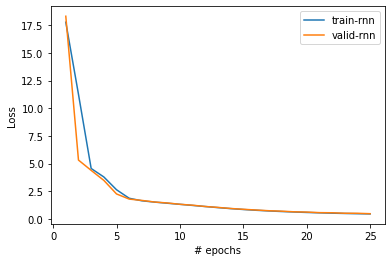

In [ ]:
# Save history for later
rnn_train_loss_history = train_loss_history
rnn_valid_loss_history = valid_loss_history

# Plot training and validation curve
xaxis = range(1, n_epoch + 1)
plt.plot(xaxis, rnn_train_loss_history, label='train-rnn')
plt.plot(xaxis, rnn_valid_loss_history, label='valid-rnn')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Training the LSTM-based model

## Defining the cost and the optimizer

Complete the following piece of code by defining the MSE criterion and the optimizer.

In [ ]:
learning_rate = 0.001

# define the Criterion
criterion = nn.MSELoss() # To complete.
# define the optimizer
optimizer_lstm = torch.optim.SGD(model_lstm.parameters(), lr=0.001) # To complete.


## Training the model

To train out model, we will use our `train_loader` object to iterate over our entire training sets *n_epoch* times. 
To measure progress we will store the validation cost at the end of each training *epoch*. We will use `n_epoch = 25`.

Complete the following piece of code with the instructions correponding to the related comments.

In [ ]:
since = time.time()


train_loss_history = []
valid_loss_history = []

num_epochs = 25

model_lstm.load_state_dict(init_lstm_weights)

print("# Start training #")

for epoch in range(num_epochs):
    
    train_loss = 0
    train_n_iter = 0
    
    # Set model to train mode
    model_lstm.train()
    torch.set_grad_enabled(True)
    
    # Iterate over train data
    for x, y in train_loader:  

        
        # Put tensors on device (GPU when available)
        xtrain = xtrain.to(device)# To complete.
        ytrain = ytrain.to(device)
        # Zero the gradient buffer
        optimizer_lstm.zero_grad() # To complete.        
        # Perform the Forward operation
        outputs = model_lstm(xtrain) # To complete.        
        # Calculate the loss using the criterion function
        loss = criterion(ytrain, outputs) # To complete.        
        # Perform the Backward operation
        loss.backward() # To complete.        
        # Perform the Optimization step
        optimizer_lstm.step() # To complete.        
        # Statistics
        train_loss += loss.item()
        train_n_iter += 1

    valid_loss = 0
    valid_n_iter = 0
    
    # Set model to evaluate mode
    model_lstm.eval()
    with torch.no_grad():
    
        # Iterate over valid data
        for x, y in valid_loader:  
        
            # Put tensors on device (GPU when available)
            xvalid = xvalid.to(device)# To complete.
            yvalid = yvalid.to(device)        
            # Perform the Forward operation
            outputs = model_lstm(xvalid) # To complete.            
            # Calculate the loss using the criterion function
            loss = criterion(yvalid, outputs) # To complete.        
            # Statistics
            valid_loss += loss.item()
            valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)
    
    print("Epoch {:2d} | Training loss = {:.5f} | Validation loss = {:.5f} "
          .format(epoch+1, (train_loss / train_n_iter), (valid_loss / valid_n_iter)))

time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

# Start training #
Epoch  1 | Training loss = 17.93247 | Validation loss = 18.75997 
Epoch  2 | Training loss = 17.89157 | Validation loss = 18.73090 
Epoch  3 | Training loss = 17.85200 | Validation loss = 18.68604 
Epoch  4 | Training loss = 17.79244 | Validation loss = 18.60485 
Epoch  5 | Training loss = 17.67804 | Validation loss = 18.42743 
Epoch  6 | Training loss = 17.37224 | Validation loss = 17.83527 
Epoch  7 | Training loss = 14.75052 | Validation loss = 9.72985 
Epoch  8 | Training loss = 6.05167 | Validation loss = 4.46650 
Epoch  9 | Training loss = 3.08505 | Validation loss = 2.43469 
Epoch 10 | Training loss = 1.62897 | Validation loss = 1.42943 
Epoch 11 | Training loss = 1.03118 | Validation loss = 1.01415 
Epoch 12 | Training loss = 0.75823 | Validation loss = 0.78584 
Epoch 13 | Training loss = 0.59674 | Validation loss = 0.64023 
Epoch 14 | Training loss = 0.48916 | Validation loss = 0.53919 
Epoch 15 | Training loss = 0.41154 | Validation loss = 0.46378 
Epoch 16

## Visualizing training curves 

Visualize the training curves using a graph of the cost function vs. epochs for both the training and the validation data.

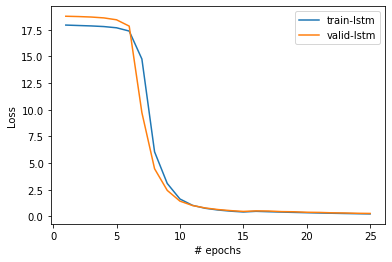

In [ ]:
# Save history for later
lstm_train_loss_history = train_loss_history
lstm_valid_loss_history = valid_loss_history

# Plot training and validation curve
xaxis = range(1, num_epochs + 1)
plt.plot(xaxis, lstm_train_loss_history, label='train-lstm')
plt.plot(xaxis, lstm_valid_loss_history, label='valid-lstm')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Analyzing the results

We will now compare the RNN and the LSTM using their performance on train/validation and test sets.

## Comparing training curves


Compare the training curves using a graph of the cost function vs. epochs for both the training and the validation data.

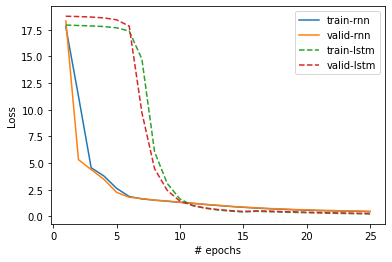

In [ ]:
# Plot training and validation curve
xaxis = range(1, num_epochs + 1)

plt.plot(xaxis, rnn_train_loss_history, label='train-rnn')
plt.plot(xaxis, rnn_valid_loss_history, label='valid-rnn')

plt.plot(xaxis, lstm_train_loss_history, label='train-lstm', linestyle='--')
plt.plot(xaxis, lstm_valid_loss_history, label='valid-lstm', linestyle='--')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#**Questions**

###1. Which network works best according to validation? Why is that? 
###Answer:
The LSTM network work best according to validation. Because, 
It is seen from the RNN architecture that the gradient vanishes after each time step which creates slow learning problem or even no learning. This vanishing gradient problem can be handled by Long Short Term Memory(LSTM) where a carry term is introduced which prevents the gradients to be vanished in the network.   

###2. Assume you want to increase the gap between the RNN and LSTM performances. How would you modify the data?
###Answer:
Since the effect of vanishing gradient increases when the time step of the sequence is increased, a increment of the sequence length will increase the performance gap between RNN and LSTM. To prove this statement, a new experimentation is done using seq_len = 50 instead of 18 in the previous case. 





In [ ]:
from torch.utils.data import DataLoader, TensorDataset

n_samples = 25000
seq_len = 50
batch_size = 64
input_dim = 1
# generate the data:
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100) # To complete.
# and standardize it:
Xs, Ys, mean, std = standardize(X) # To complete.
xtrain, ytrain = Xs[:round(0.8*n_samples)], Ys[:round(0.8*n_samples)]
xvalid, yvalid = Xs[round(0.8*n_samples):round(0.9*n_samples)], Ys[round(0.8*n_samples):round(0.9*n_samples)]
xtest, ytest = Xs[round(0.9*n_samples):], Ys[round(0.9*n_samples):]

# dataloader for the training dataset
train_loader = DataLoader(TensorDataset(xtrain, ytrain), batch_size, shuffle=True)

# do the dataloader for the validation dataset
valid_loader = DataLoader(TensorDataset(xvalid, yvalid), batch_size, shuffle=True) # To complete.
# dataloader for the test dataset
test_loader = DataLoader(TensorDataset(xtest, ytest), batch_size, shuffle=True) # To complete.

#### RNN Network:

In [ ]:
learning_rate = 0.001

# Define the Criterion
criterion = nn.MSELoss() # To complete.

# Define the Optimizer
optimizer_rnn = torch.optim.SGD(model_rnn.parameters(), lr=0.001) # To complete.

In [ ]:
since = time.time()


train_loss_history = []
valid_loss_history = []

n_epoch = 25

model_rnn.load_state_dict(init_rnn_weights)

print("Start training")

for epoch in range(n_epoch):
    
    train_loss = 0
    train_n_iter = 0
    
    # Set model to train mode
    model_rnn.train()
    torch.set_grad_enabled(True)
    
    # Iterate over train data
    for x, y in train_loader:  

        
        # Put tensors on device (GPU when available)
        xtrain = xtrain.to(device)# To complete.
        ytrain = ytrain.to(device)
        # Zero the gradient buffer
        optimizer_rnn.zero_grad() # To complete.        
        # Perform the Forward operation

        # Use the RNN to predict the output of each input sequence prior to training
        # Ensure that the inputs and output are correct
        outputs = model_rnn(xtrain)       
        # Calculate the loss using the criterion function
        loss = criterion(ytrain, outputs) # To complete.        
        # Perform the Backward operation
        loss.backward() # To complete.        
        # Perform the Optimization step
        optimizer_rnn.step() # To complete.        
        # Statistics
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Set model to evaluate mode
    model_rnn.eval()
    with torch.no_grad():
    
        # Iterate over valid data
        for x, y in valid_loader:  
        
            # Put tensors on device (GPU when available)
            xvalid = xvalid.to(device)# To complete.
            yvalid = yvalid.to(device) # To complete.        
            # Perform the Forward operation
            outputs = model_rnn(xvalid) # To complete.            
            # Calculate the loss using the criterion function
            loss = criterion(yvalid, outputs) # To complete.        
            # Statistics
            valid_loss += loss.item()
            valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)


    print("Epoch {:2d} | Training loss = {:.5f} | Validation loss = {:.5f} "
          .format(epoch+1, (train_loss / train_n_iter), (valid_loss / valid_n_iter)))

time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

# Save history for later
rnn_train_loss_history = train_loss_history
rnn_valid_loss_history = valid_loss_history

Start training
Epoch  1 | Training loss = 50.08212 | Validation loss = 47.77029 
Epoch  2 | Training loss = 41.18290 | Validation loss = 27.36567 
Epoch  3 | Training loss = 28.99461 | Validation loss = 24.27049 
Epoch  4 | Training loss = 21.42449 | Validation loss = 15.66950 
Epoch  5 | Training loss = 15.37470 | Validation loss = 14.98805 
Epoch  6 | Training loss = 11.52670 | Validation loss = 11.80560 
Epoch  7 | Training loss = 8.85882 | Validation loss = 6.54519 
Epoch  8 | Training loss = 7.33799 | Validation loss = 4.55651 
Epoch  9 | Training loss = 23.26705 | Validation loss = 36.10926 
Epoch 10 | Training loss = 49.01432 | Validation loss = 47.15437 
Epoch 11 | Training loss = 45.36445 | Validation loss = 40.97234 
Epoch 12 | Training loss = 40.07884 | Validation loss = 46.18089 
Epoch 13 | Training loss = 35.37524 | Validation loss = 36.99791 
Epoch 14 | Training loss = 29.95451 | Validation loss = 20.05111 
Epoch 15 | Training loss = 23.77875 | Validation loss = 20.30213 

####LSTM Network:

In [ ]:
learning_rate = 0.001

# define the Criterion
criterion = nn.MSELoss() # To complete.
# define the optimizer
optimizer_lstm = torch.optim.SGD(model_lstm.parameters(), lr=0.001) # To complete.


In [ ]:
since = time.time()


train_loss_history = []
valid_loss_history = []

num_epochs = 25

model_lstm.load_state_dict(init_lstm_weights)

print("# Start training #")

for epoch in range(num_epochs):
    
    train_loss = 0
    train_n_iter = 0
    
    # Set model to train mode
    model_lstm.train()
    torch.set_grad_enabled(True)
    
    # Iterate over train data
    for x, y in train_loader:  

        
        # Put tensors on device (GPU when available)
        xtrain = xtrain.to(device)# To complete.
        ytrain = ytrain.to(device)
        # Zero the gradient buffer
        optimizer_lstm.zero_grad() # To complete.        
        # Perform the Forward operation
        outputs = model_lstm(xtrain) # To complete.        
        # Calculate the loss using the criterion function
        loss = criterion(ytrain, outputs) # To complete.        
        # Perform the Backward operation
        loss.backward() # To complete.        
        # Perform the Optimization step
        optimizer_lstm.step() # To complete.        
        # Statistics
        train_loss += loss.item()
        train_n_iter += 1

    valid_loss = 0
    valid_n_iter = 0
    
    # Set model to evaluate mode
    model_lstm.eval()
    with torch.no_grad():
    
        # Iterate over valid data
        for x, y in valid_loader:  
        
            # Put tensors on device (GPU when available)
            xvalid = xvalid.to(device)# To complete.
            yvalid = yvalid.to(device)        
            # Perform the Forward operation
            outputs = model_lstm(xvalid) # To complete.            
            # Calculate the loss using the criterion function
            loss = criterion(yvalid, outputs) # To complete.        
            # Statistics
            valid_loss += loss.item()
            valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)
    
    print("Epoch {:2d} | Training loss = {:.5f} | Validation loss = {:.5f} "
          .format(epoch+1, (train_loss / train_n_iter), (valid_loss / valid_n_iter)))

time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

# Save history for later
lstm_train_loss_history = train_loss_history
lstm_valid_loss_history = valid_loss_history

# Start training #
Epoch  1 | Training loss = 50.24119 | Validation loss = 48.26094 
Epoch  2 | Training loss = 50.19949 | Validation loss = 48.23835 
Epoch  3 | Training loss = 50.15906 | Validation loss = 48.19877 
Epoch  4 | Training loss = 50.09768 | Validation loss = 48.12391 
Epoch  5 | Training loss = 49.97777 | Validation loss = 47.95601 
Epoch  6 | Training loss = 49.63991 | Validation loss = 47.34635 
Epoch  7 | Training loss = 42.91415 | Validation loss = 29.04868 
Epoch  8 | Training loss = 23.65297 | Validation loss = 16.00839 
Epoch  9 | Training loss = 13.44522 | Validation loss = 10.71836 
Epoch 10 | Training loss = 9.42042 | Validation loss = 7.69899 
Epoch 11 | Training loss = 6.89363 | Validation loss = 5.71183 
Epoch 12 | Training loss = 5.22390 | Validation loss = 4.41545 
Epoch 13 | Training loss = 4.20765 | Validation loss = 3.73161 
Epoch 14 | Training loss = 3.52667 | Validation loss = 3.13024 
Epoch 15 | Training loss = 3.06307 | Validation loss = 2.78112 
Epo

####Performance Comparison

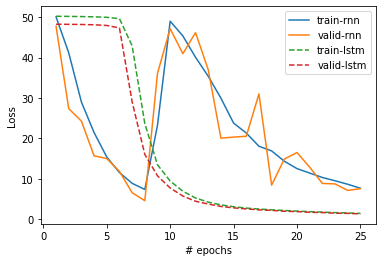

In [ ]:
# Plot training and validation curve
xaxis = range(1, num_epochs + 1)

plt.plot(xaxis, rnn_train_loss_history, label='train-rnn')
plt.plot(xaxis, rnn_valid_loss_history, label='valid-rnn')

plt.plot(xaxis, lstm_train_loss_history, label='train-lstm', linestyle='--')
plt.plot(xaxis, lstm_valid_loss_history, label='valid-lstm', linestyle='--')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Here, it is found that increasing the sequence length affects the performance of RNN and creating vanishing gradient problems. However, the training time must be sacrificed. 

## Evaluating test error

Complete the following piece of code in order to evaluate and print the mean squared error on the test set for both models.

In [ ]:
# Put sequence data on device (GPU when available)
xtest = xtest.to(device) # To complete.
# Put target data on device (GPU when available)
ytest = ytest.to(device) # To complete.
# Predict the value of the sequence data using the RNN-based model
ypred_rnn = model_rnn(xtest) # To complete.
# Predict the value of the sequence data using the LSTM-based model
ypred_lstm = model_lstm(xtest) # To complete.
# Compute the loss of the RNN-based model using the criterion function
loss_test_rnn = criterion(ytest, ypred_rnn) # To complete.
# Compute the loss of the LSTM-based model using the criterion function
loss_test_lstm = criterion(ytest, ypred_lstm) # To complete.

print("The RNN's test mean squared error is %2.3f" % float(loss_test_rnn))
print("The LSTM's test mean squared error is %2.3f" % float(loss_test_lstm))

The RNN's test mean squared error is 7.670
The LSTM's test mean squared error is 1.351


## Further exploring the results

To gain insights into our models we will inspect their outputs (i.e., their predictions before calculating the cost). To help us we will define a `print_sequence()` function. 

This function takes as input the tensors X and Y, samples a particular entry (sequence), prints the entry and prints the absolute difference between the true Y and the predicted Y.

Recall that we have standardized our examples. For these visualizations we wish to use the original data pre-standardization. To do so, we use `mean` + `std` such that $xtest\_unstd = xtest*std + mean$ et $ytest\_unstd = ytest*std+seq\_len*mean$.


In [ ]:
def print_sequence(X, Y, idx=0):
    """Print ground truth sum and predicted values.
    Args:
      X: torch.Tensor.
      Y: torch.Tensor.
      idx: index of the sequence (entry) to use.
    """
    x = X[idx].numpy()
    y = Y[idx].numpy()
    for i, xi in enumerate(x):
        if i==0:
            string = str(xi[0]) 
        else:
            string += " + " + str(xi[0])
            
    print("Sequence: ", string)
    print("Prediction: ", str(y[0]))
    print("Ground truth value: ", str(np.sum(x)))
    diff = abs(np.sum(x)-y[0])
    print("Absolute error between X[{a}] et Y[{a}]: {b}".format(a=idx, b=diff))

Complete the following piece of code by unstandardizing `xtest` and `ypred_rnn` values.

In [ ]:
xtest = xtest.cpu()
ypred_rnn = ypred_rnn.cpu()

# Unstandardize  xtest
xtest_unstd = (xtest+ std) + mean 
# Unstandardize  the predictions of the RNN-based model on xtest
ypred_unstd = ypred_rnn*std + seq_len*mean # To complete.
idx = np.random.randint(len(ytest))


print("")
print("Example RNN:")
print("")

print_sequence(xtest_unstd.detach(), ypred_unstd.detach(), idx=idx)



xtest = xtest.cpu()
ypred_lstm = ypred_lstm.cpu()

xtest_unstd = xtest*std + mean
ypred_unstd = ypred_lstm*std + seq_len*mean

print("")
print("Example LSTM:")
print("")

print_sequence(xtest_unstd.detach(), ypred_unstd.detach(), idx=idx)


Example RNN:

Sequence:  59.317036 + 59.230843 + 58.868824 + 57.558666 + 58.851585 + 56.989784 + 57.403515 + 59.42047 + 58.179268 + 57.903446 + 59.179127 + 59.43771 + 57.81725 + 56.85187 + 59.385994 + 57.127693 + 59.28256 + 58.541286 + 57.3518 + 59.506664 + 59.42047 + 58.213745 + 56.989784 + 59.26532 + 59.73077 + 57.67934 + 58.61024 + 59.006737 + 56.920826 + 58.299942 + 59.317036 + 57.903446 + 59.299797 + 58.024117 + 58.696438 + 58.041355 + 58.179268 + 58.110313 + 58.024117 + 56.300224 + 57.300083 + 56.55881 + 59.644577 + 58.282703 + 59.299797 + 58.61024 + 59.196365 + 57.0415 + 58.903305 + 58.179268
Prediction:  835.43353
Ground truth value:  2917.2554
Absolute error between X[1424] et Y[1424]: 2081.82177734375

Example LSTM:

Sequence:  76.0 + 71.0 + 50.0 + -26.0 + 49.0 + -58.999996 + -35.0 + 82.0 + 10.0 + -6.0 + 68.0 + 83.0 + -11.0 + -67.0 + 80.0 + -51.0 + 74.0 + 31.000002 + -38.0 + 87.0 + 82.0 + 12.0 + -58.999996 + 73.0 + 100.0 + -19.0 + 35.0 + 58.0 + -63.0 + 17.0 + 76.0 + -6.0 + 7

** Bonus exercise**

* Redo the above analysis but instead of summing the input values try other operations (e.g., product)
* Compare the performance of the RNN and the LSTM for sequences of different length (i.e., change `seq_len`)